# Predicting Hand Drawn Characters

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import Model

from PIL import Image
import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

In [4]:
from emnist import list_datasets
from emnist import extract_training_samples, extract_test_samples

In [5]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

### Load Data

In [6]:
X_train, train_labels = extract_training_samples('byclass')

In [7]:
X_train.shape, train_labels.shape

((697932, 28, 28), (697932,))

In [8]:
X_test, test_labels = extract_test_samples('byclass')

In [9]:
X_test.shape, test_labels.shape

((116323, 28, 28), (116323,))

(<matplotlib.image.AxesImage at 0x7f61ae80c198>, 32)

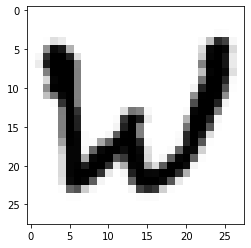

In [10]:
i = 300107
plt.imshow(X_train[i], cmap=plt.cm.binary), train_labels[i]

In [11]:
pd.Series(train_labels).value_counts().sort_index()

0     34585
1     38374
2     34203
3     35143
4     33535
      ...  
57     2910
58     2697
59     2822
60     2365
61     2725
Length: 62, dtype: int64

#### Remove Uppercase

In [12]:
def remove_upper(X_old, labels):
    nums = list(range(0, 10))
    upper = list(range(10, 36))
    lower = list(range(36, 62))
    X = []
    y = []
    for x, lab in zip(X_old, labels):
        if lab in nums:
            X.append(x)
            y.append(lab)
        elif lab in upper:
            continue
        elif lab in lower:
            lab -= 26
            X.append(x)
            y.append(lab)
    
    return np.array(X), np.array(y)

In [13]:
X_train, train_labels = remove_upper(X_train, train_labels)
X_test, test_labels = remove_upper(X_test, test_labels)

In [14]:
X_train.shape, train_labels.shape, X_test.shape, test_labels.shape

((508974, 28, 28), (508974,), (84977, 28, 28), (84977,))

#### Merge Train and Test

In [15]:
X = np.vstack((X_train, X_test))
labels = np.hstack((train_labels, test_labels))

In [16]:
X.shape, labels.shape

((593951, 28, 28), (593951,))

## Model

In [17]:
#chars = '0123456789' + string.ascii_uppercase + string.ascii_lowercase
chars = '0123456789' + string.ascii_lowercase

In [18]:
num_chars = len(chars) ; num_chars

36

In [19]:
X_train = X_train.reshape(-1, 28, 28, 1)

In [20]:
# 1-9: numbers
# 10-35: uppercase
# 36-61: lowercase

y_train = np.zeros((len(train_labels), num_chars))

for i, j in enumerate(train_labels):
    y_train[i, j] = 1

In [21]:
X_train.shape, y_train.shape, y_train.sum()

((508974, 28, 28, 1), (508974, 36), 508974.0)

In [22]:
X_test = X_test.reshape(-1, 28, 28, 1)

In [23]:
# 1-9: numbers
# 10-35: uppercase
# 36-61: lowercase

y_test = np.zeros((len(test_labels), num_chars))

for i, j in enumerate(test_labels):
    y_test[i, j] = 1

In [24]:
X_test.shape, y_test.shape, y_test.sum()

((84977, 28, 28, 1), (84977, 36), 84977.0)

In [ ]:
# Model Outline
input_shape = (28, 28, 1)

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(32, (5,5), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(64, (5,5), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(32, (5,5), padding='same', activation='relu')(mp2)
mp3 = MaxPooling2D(padding='same')(cn3)   

cn4 = Conv2D(16, (5,5), padding='same', activation='relu')(mp3)
mp4 = MaxPooling2D(padding='same')(cn4)   

# Flatten and Dense layers
flat = Flatten()(mp4)
dens1 = Dense(128, activation='relu')(flat)
#drop = Dropout(0.5)(dens1)
bn = BatchNormalization()(dens1)
output = Dense(num_chars, activation='softmax')(bn)#(drop)


In [99]:
# Compile model
model = Model(imgm, output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [100]:
model.summary();

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 32)          51232     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 4, 4, 32)          0  

In [101]:
history = model.fit(X_train, train_labels, batch_size=256, epochs=10, verbose=2, validation_split=0.2)

Train on 407179 samples, validate on 101795 samples
Epoch 1/10
407179/407179 - 28s - loss: 0.3217 - accuracy: 0.9029 - val_loss: 0.3394 - val_accuracy: 0.8907
Epoch 2/10
407179/407179 - 27s - loss: 0.2049 - accuracy: 0.9295 - val_loss: 0.2439 - val_accuracy: 0.9201
Epoch 3/10
407179/407179 - 27s - loss: 0.1911 - accuracy: 0.9331 - val_loss: 0.2107 - val_accuracy: 0.9290
Epoch 4/10
407179/407179 - 27s - loss: 0.1803 - accuracy: 0.9361 - val_loss: 0.1959 - val_accuracy: 0.9329
Epoch 5/10
407179/407179 - 27s - loss: 0.1722 - accuracy: 0.9385 - val_loss: 0.2489 - val_accuracy: 0.9159
Epoch 6/10
407179/407179 - 27s - loss: 0.1651 - accuracy: 0.9401 - val_loss: 0.1953 - val_accuracy: 0.9327
Epoch 7/10
407179/407179 - 27s - loss: 0.1617 - accuracy: 0.9412 - val_loss: 0.1929 - val_accuracy: 0.9329
Epoch 8/10
407179/407179 - 27s - loss: 0.1533 - accuracy: 0.9433 - val_loss: 0.1983 - val_accuracy: 0.9326
Epoch 9/10
407179/407179 - 27s - loss: 0.1494 - accuracy: 0.9448 - val_loss: 0.1967 - val_ac

In [105]:
eval1 = model.evaluate(X_test, test_labels, verbose=2)

84977/84977 - 7s - loss: 0.1886 - accuracy: 0.9357


In [ ]:
# 32/64/32 (5): loss: 0.1852 - accuracy: 0.9364
# 64/96/32 (5): loss: 0.1902 - accuracy: 0.9371

# 32/64/32/16 (5): loss: 0.1877 - accuracy: 0.9365

# filter size 5
# 84977/84977 - 7s - loss: 0.1908 - accuracy: 0.9372

#### Save Model

In [ ]:
#model.save('draw_model.h5')

In [106]:
from tensorflow import keras
model = keras.models.load_model('models/draw_model.h5')

In [107]:
def predict_test(X_test, labels):
    count = len(X_test)
    correct = 0
    all_preds = np.array(model.predict(X_test))
    
    for i, pr in enumerate(all_preds):
        
        if labels[i] == np.argmax(pr):
            correct += 1
        #c = chars[np.argmax(pr)]    
        elif np.argmax(pr) ==1 or np.argmax(pr)==21:
            correct +=1
        #else:
            #print(labels[i], np.argmax(pr))
            
    return (correct / count)

In [86]:
chars[26]

'q'

## Splitting Handwritten CAPTCHA

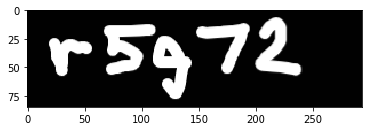

In [184]:
# example from 100,000 image dataset 
img=cv2.imread('data/i_drew.png', cv2.IMREAD_UNCHANGED)[:,:,0]

plt.imshow(img, cmap=plt.cm.binary)

In [186]:
img.shape

(85, 293)

In [187]:
# remove background and flip color
flatimg = pd.Series(img.flatten()) 
flatimg = flatimg.apply(lambda x: 255 if x > 150 else x)
flatimg = flatimg.apply(lambda x: np.abs(x - 255))
img = flatimg.values.reshape(85,293)

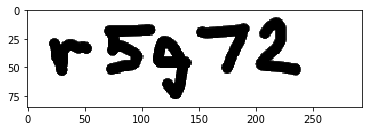

In [188]:
plt.imshow(img, cmap=plt.cm.binary)

In [189]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(37, 42)
(48, 49)
(59, 38)
(48, 51)
(55, 45)


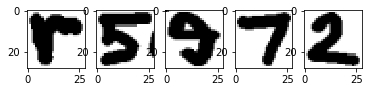

In [191]:
# Load the image and convert it to grayscale
image = cv2.imread('data/i_drew.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Hack for compatibility with different OpenCV versions
contours = contours[0] #if imutils.is_cv2() else contours[1]

letter_image_regions = []

# Now we can loop through each of the four contours and extract the letter
# inside of each one
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)

    # Compare the width and height of the contour to detect letters that
    # are conjoined into one chunk
    if w / h > 1.25:
        # This contour is too wide to be a single letter!
        # Split it in half into two letter regions!
        half_width = int(w / 2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))
    else:
        # This is a normal letter by itself
        letter_image_regions.append((x, y, w, h))

        
# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

fig, axs = plt.subplots(1,5)
axs = axs.flatten()
# Save out each letter as a single image
for i,letter_bounding_box in enumerate(letter_image_regions):   #, letter_text in zip( , captcha_correct_text):
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = thresh[y - 2:y + h + 2, x - 2:x + w + 2]
    print(letter_image.shape)
    resized = cv2.resize(letter_image, (28,28), interpolation = cv2.INTER_AREA)
    
    #axs[i].imshow(letter_image, cmap=plt.cm.binary)
    axs[i].imshow(resized, cmap=plt.cm.binary)

In [143]:
predict_drawn('data/i_drew.png')

'p5g72'

In [144]:
predict_drawn('data/nolined.png')

'73ze5'

In [145]:
predict_drawn('data/lined.png')

'8h'

## Function Testing

In [ ]:
# function to split handwritten captcha
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

# function to split handwritten captcha
def split_drawn(drawn_img):
    thresh = drawn_img.copy()

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    letter_image_regions = []

    # Iterate through the contours
    for contour in contours:
        # Find location of each character
        (x, y, w, h) = cv2.boundingRect(contour)

        """# If width/height is too large to be a one character, split it
        if w / h > 1.5:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:"""
        letter_image_regions.append((x, y, w, h))

    # Sort the characters
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Add each resized character to an array
    char_lst = []
    for i, letter_bounding_box in enumerate(letter_image_regions):
        # Get location of character
        x, y, w, h = letter_bounding_box

        # Extract the character
        letter_image = thresh[y - 2:y + h + 2, x - 2:x + w + 2]
        
        # Resize the character
        resized = cv2.resize(letter_image, (28,28), interpolation = cv2.INTER_AREA)
        resized = resized.reshape(28,28,1)

        char_lst.append(resized)
    
    return np.array(char_lst)

# function to predict drawn captcha
def predict_drawn(model, img):
    chars = '0123456789' + string.ascii_lowercase
    
    # split the drawn image
    split_img = split_drawn(img)
    
    # predict each character
    pred_arr = model.predict(split_img)
    
    pred = ''
    for i in pred_arr:
        c = chars[np.argmax(i)]
        pred += c

    return pred

In [2]:
# Load the image and convert it to grayscale
image = cv2.imread('../data/nolined.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [3]:
thresh.shape

(96, 285)

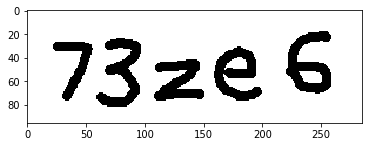

In [4]:
plt.imshow(thresh, cmap=plt.cm.binary)